Stanford Dog breed dataset from https://www.kaggle.com/c/dog-breed-identification/data

In [1]:
from keras import regularizers
from keras.models import Model
from keras.optimizers import Adam
from keras.layers import Dropout
from keras.layers import GlobalAveragePooling2D
from keras.layers import BatchNormalization
from keras.layers import Activation,Dense
from keras.models import Sequential,load_model
from keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from keras.applications.inception_v3 import InceptionV3
import numpy as np
import pandas as pd
from numpy.random import rand
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score
from sklearn.metrics import confusion_matrix,classification_report
import matplotlib.pyplot as plt
from IPython.display import display, HTML
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
pd.options.display.max_colwidth = 600

Using TensorFlow backend.


In [2]:
train_folder = 'train/'

In [3]:
data_labels = pd.read_csv('labels.csv')
data_labels.head()

,id,breed
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo
2,001cdf01b096e06d78e9e5112d419397,pekinese
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever


In [4]:
target_labels = data_labels['breed']
# Dog Breed Classes
len(set(target_labels))

120

In [5]:
# one hot encoding target classes
labels_ohe_names = pd.get_dummies(target_labels, sparse=True)
labels_ohe = np.asarray(labels_ohe_names)
print(labels_ohe.shape)
print(labels_ohe[:2])

(10222, 120)
[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0]]


We add another column to the labels dataset to identify image path

In [6]:
data_labels['image_path'] = data_labels.apply( lambda row: (train_folder + row["id"] + ".jpg" ), axis=1)
data_labels.head()

,id,breed,image_path
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull,train/000bec180eb18c7604dcecc8fe0dba07.jpg
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo,train/001513dfcb2ffafc82cccf4d8bbaba97.jpg
2,001cdf01b096e06d78e9e5112d419397,pekinese,train/001cdf01b096e06d78e9e5112d419397.jpg
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick,train/00214f311d5d2247d5dfe4fe24b2303d.jpg
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever,train/0021f9ceb3235effd7fcde7f7538ed62.jpg


## Preparing Train-Test-Validation

In [7]:
train_data = np.array([img_to_array(load_img(img, target_size=(299, 299))) for img 
                           in data_labels['image_path'].values.tolist()]).astype('float32')

In [8]:
train_data.shape

(10222, 299, 299, 3)

In [9]:
x_train, x_test, y_train, y_test = train_test_split(train_data, 
                                                    target_labels, 
                                                    test_size=0.3, 
                                                    stratify=np.array(target_labels), 
                                                    random_state=42)

In [10]:
x_train.shape, x_test.shape

((7155, 299, 299, 3), (3067, 299, 299, 3))

In [11]:
x_train, x_val, y_train, y_val = train_test_split(x_train, 
                                                    y_train, 
                                                    test_size=0.15, 
                                                    stratify=np.array(y_train), 
                                                    random_state=42)

In [12]:
x_train.shape, x_val.shape

((6081, 299, 299, 3), (1074, 299, 299, 3))

Preparing target variables for train, test and validation datasets

In [13]:
y_train_ohe = pd.get_dummies(y_train.reset_index(drop=True)).values
y_val_ohe = pd.get_dummies(y_val.reset_index(drop=True)).values
y_test_ohe = pd.get_dummies(y_test.reset_index(drop=True)).values

y_train_ohe.shape, y_test_ohe.shape, y_val_ohe.shape

((6081, 120), (3067, 120), (1074, 120))

## Data Augmentation

In [14]:
train_datagen = ImageDataGenerator(rescale=1./255, 
                                   rotation_range=30, 
                                   width_shift_range=0.2,
                                   height_shift_range=0.2, 
                                   horizontal_flip = 'true')
val_datagen = ImageDataGenerator(rescale = 1./255)

In [15]:
BATCH_SIZE = 32

train_generator = train_datagen.flow(x_train, y_train_ohe, shuffle=False, batch_size=BATCH_SIZE, seed=42)
val_generator = train_datagen.flow(x_val, y_val_ohe, shuffle=False, batch_size=BATCH_SIZE, seed=42)

## Deep Learning Classifier

In [16]:
# Loading pretrained InceptionV3  on ImageNet without its top/classification layer
base_inception = InceptionV3(weights='imagenet', include_top = False, input_shape=(299, 299, 3))

Instructions for updating:
Colocations handled automatically by placer.
87916544/87910968 [==============================] - 1s 0us/step


In [17]:
# Adding additional custom layers on top of InceptionV3 to prepare custom classifier
out = base_inception.output
out = GlobalAveragePooling2D()(out)
out = Dense(512, activation='relu')(out)
out = Dense(512, activation='relu')(out)
total_classes = y_train_ohe.shape[1]
predictions = Dense(total_classes, activation='softmax')(out)

In [18]:
# Stacking the two models (InceptionV3 and custom layers) on top of each other
model = Model(inputs=base_inception.input, outputs=predictions)

# freezing layers
for layer in base_inception.layers:
    layer.trainable = False

model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 299, 299, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 149, 149, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 149, 149, 32) 96          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 149, 149, 32) 0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
conv2d_2 (

In [19]:
# Compiling Model
model.compile(Adam(lr=.0001), loss='categorical_crossentropy', metrics=['accuracy'])

## Training InceptionV3 Model

In [20]:
batch_size = BATCH_SIZE
train_steps_per_epoch = x_train.shape[0] // batch_size
val_steps_per_epoch = x_val.shape[0] // batch_size

history = model.fit_generator(train_generator,
                              steps_per_epoch=train_steps_per_epoch,
                              validation_data=val_generator,
                              validation_steps=val_steps_per_epoch,
                              epochs=15,
                              verbose=1)

Instructions for updating:
Use tf.cast instead.
Epoch 1/15
190/190 [==============================] - 868s 5s/step - loss: 4.1145 - acc: 0.2273 - val_loss: 2.5261 - val_acc: 0.6117
Epoch 2/15
190/190 [==============================] - 844s 4s/step - loss: 2.1530 - acc: 0.5745 - val_loss: 1.0572 - val_acc: 0.7543
Epoch 3/15
190/190 [==============================] - 821s 4s/step - loss: 1.3777 - acc: 0.6722 - val_loss: 0.7988 - val_acc: 0.7879
Epoch 4/15
190/190 [==============================] - 820s 4s/step - loss: 1.1341 - acc: 0.7099 - val_loss: 0.7159 - val_acc: 0.8052
Epoch 5/15
190/190 [==============================] - 827s 4s/step - loss: 1.0044 - acc: 0.7272 - val_loss: 0.6656 - val_acc: 0.8042
Epoch 6/15
190/190 [==============================] - 828s 4s/step - loss: 0.9231 - acc: 0.7436 - val_loss: 0.6631 - val_acc: 0.7860
Epoch 7/15
190/190 [==============================] - 823s 4s/step - loss: 0.8628 - acc: 0.7587 - val_loss: 0.6627 - val_acc: 0.8071
Epoch 8/15
190/190 [=

In [21]:
model.save('dog_breed_inceptionv3.hdf5')

## Visualize Model Performance

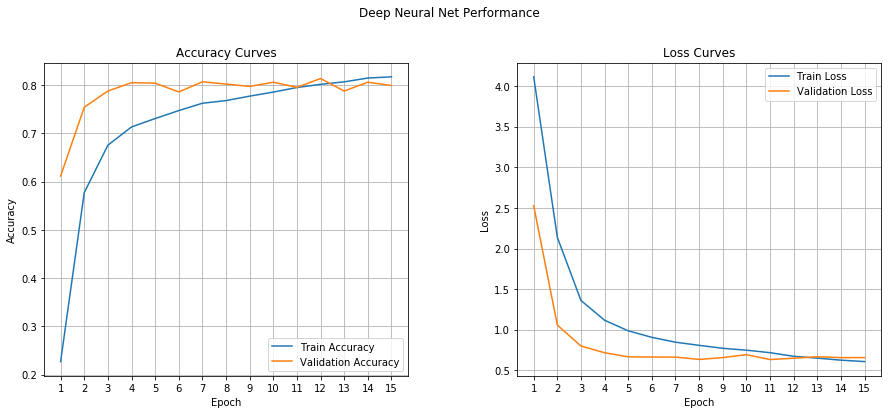

In [22]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
t = f.suptitle('Deep Neural Net Performance', fontsize=12)
f.subplots_adjust(top=0.85, wspace=0.3)

epochs = list(range(1,16))
ax1.plot(epochs, history.history['acc'], label='Train Accuracy')
ax1.plot(epochs, history.history['val_acc'], label='Validation Accuracy')
ax1.grid()
ax1.set_xticks(epochs)
ax1.set_ylabel('Accuracy')
ax1.set_xlabel('Epoch')
ax1.set_title('Accuracy Curves')
l1 = ax1.legend(loc="best")

ax2.plot(epochs, history.history['loss'], label='Train Loss')
ax2.plot(epochs, history.history['val_loss'], label='Validation Loss')
ax2.grid()
ax2.set_xticks(epochs)
ax2.set_ylabel('Loss')
ax2.set_xlabel('Epoch')
ax2.set_title('Loss Curves')
l2 = ax2.legend(loc="best")

## Testing Model Performance

In [23]:
# scaling test features
x_test /= 255.

In [24]:
test_predictions = model.predict(x_test)

In [25]:
predictions = pd.DataFrame(test_predictions, columns=labels_ohe_names.columns)
predictions.head()

,affenpinscher,afghan_hound,african_hunting_dog,airedale,american_staffordshire_terrier,appenzeller,australian_terrier,basenji,basset,beagle,...,toy_poodle,toy_terrier,vizsla,walker_hound,weimaraner,welsh_springer_spaniel,west_highland_white_terrier,whippet,wire-haired_fox_terrier,yorkshire_terrier
0,1.754357e-07,1.414786e-07,3.212762e-06,2.297546e-07,2.902967e-03,1.230860e-05,5.153862e-08,7.692917e-06,4.359637e-06,1.297991e-05,...,3.844377e-08,1.572664e-06,1.375456e-04,3.453719e-05,2.390644e-04,4.994075e-06,2.955075e-07,2.415868e-02,0.000001,6.817324e-07
1,1.308803e-06,4.855588e-07,9.157887e-05,9.289996e-06,1.724629e-04,6.943486e-05,5.993353e-05,1.101622e-03,7.937657e-06,1.943498e-02,...,2.325560e-06,2.596033e-02,1.316263e-05,1.067822e-04,3.106615e-03,1.226495e-06,1.082696e-04,1.743201e-03,0.000279,8.401602e-05
2,2.791744e-06,2.307148e-07,8.372845e-07,1.856676e-04,4.208630e-05,7.447780e-01,4.491196e-06,1.242984e-03,1.416104e-05,1.497265e-05,...,6.125669e-07,1.863115e-05,2.191246e-06,4.522609e-05,8.979171e-07,9.059888e-07,9.495936e-06,5.007606e-06,0.000010,3.244110e-05
3,2.051232e-08,3.554373e-05,4.854409e-07,6.351250e-07,2.141942e-07,2.149728e-09,9.788814e-07,2.508941e-07,4.497820e-06,1.470790e-05,...,4.612185e-05,1.730025e-07,3.016753e-07,6.554486e-07,1.466903e-06,1.520572e-05,1.029659e-06,5.653476e-08,0.000001,7.599560e-07
4,5.012445e-08,1.201581e-06,2.841484e-06,3.605741e-07,4.355266e-06,3.658425e-07,6.205286e-07,1.511422e-07,2.367076e-07,1.915652e-07,...,1.228784e-06,3.223526e-06,1.272145e-07,7.962765e-08,2.231986e-07,2.971288e-08,2.121208e-02,9.734720e-07,0.000027,5.393704e-07


In [26]:
test_labels = list(y_test)
predictions = list(predictions.idxmax(axis=1))

## Analyze Test Performance

In [32]:
print('Accuracy:', np.round(accuracy_score(test_labels, predictions),4))
print('Precision:', np.round(precision_score(test_labels, predictions,average='weighted'),4))
print('Recall:', np.round(recall_score(test_labels, predictions,average='weighted'),4))
print('F1-Score:', np.round(f1_score(test_labels, predictions,average='weighted'),4))

Accuracy: 0.8722
Precision: 0.885
Recall: 0.8722
F1-Score: 0.8691


In [33]:
class_n=list(labels_ohe_names.columns)

In [35]:
print(classification_report(test_labels, predictions, labels=class_n))

                                precision    recall  f1-score   support

                 affenpinscher       1.00      0.83      0.91        24
                  afghan_hound       0.97      0.97      0.97        35
           african_hunting_dog       1.00      0.96      0.98        26
                      airedale       0.86      0.97      0.91        32
american_staffordshire_terrier       0.78      0.64      0.70        22
                   appenzeller       0.86      0.78      0.82        23
            australian_terrier       0.96      0.81      0.88        31
                       basenji       1.00      0.88      0.94        33
                        basset       0.86      0.96      0.91        25
                        beagle       0.88      0.97      0.92        31
            bedlington_terrier       1.00      1.00      1.00        27
          bernese_mountain_dog       0.83      1.00      0.91        34
       black-and-tan_coonhound       0.83      0.87      0.85  

In [37]:
classes=class_n
total_classes = len(classes)
level_labels = [total_classes*[0], list(range(total_classes))]

cm = confusion_matrix(test_labels,predictions, labels=classes)
cm_frame = pd.DataFrame(data=cm, 
                        columns=pd.MultiIndex(levels=[['Predicted:'], classes], 
                                              labels=level_labels), 
                        index=pd.MultiIndex(levels=[['Actual:'], classes], 
                                            labels=level_labels)) 
print(cm)

[[20  0  0 ...  0  0  0]
 [ 0 34  0 ...  0  0  0]
 [ 0  0 25 ...  0  0  0]
 ...
 [ 0  0  0 ... 17  0  0]
 [ 0  0  0 ...  0 13  0]
 [ 0  0  0 ...  0  0 18]]


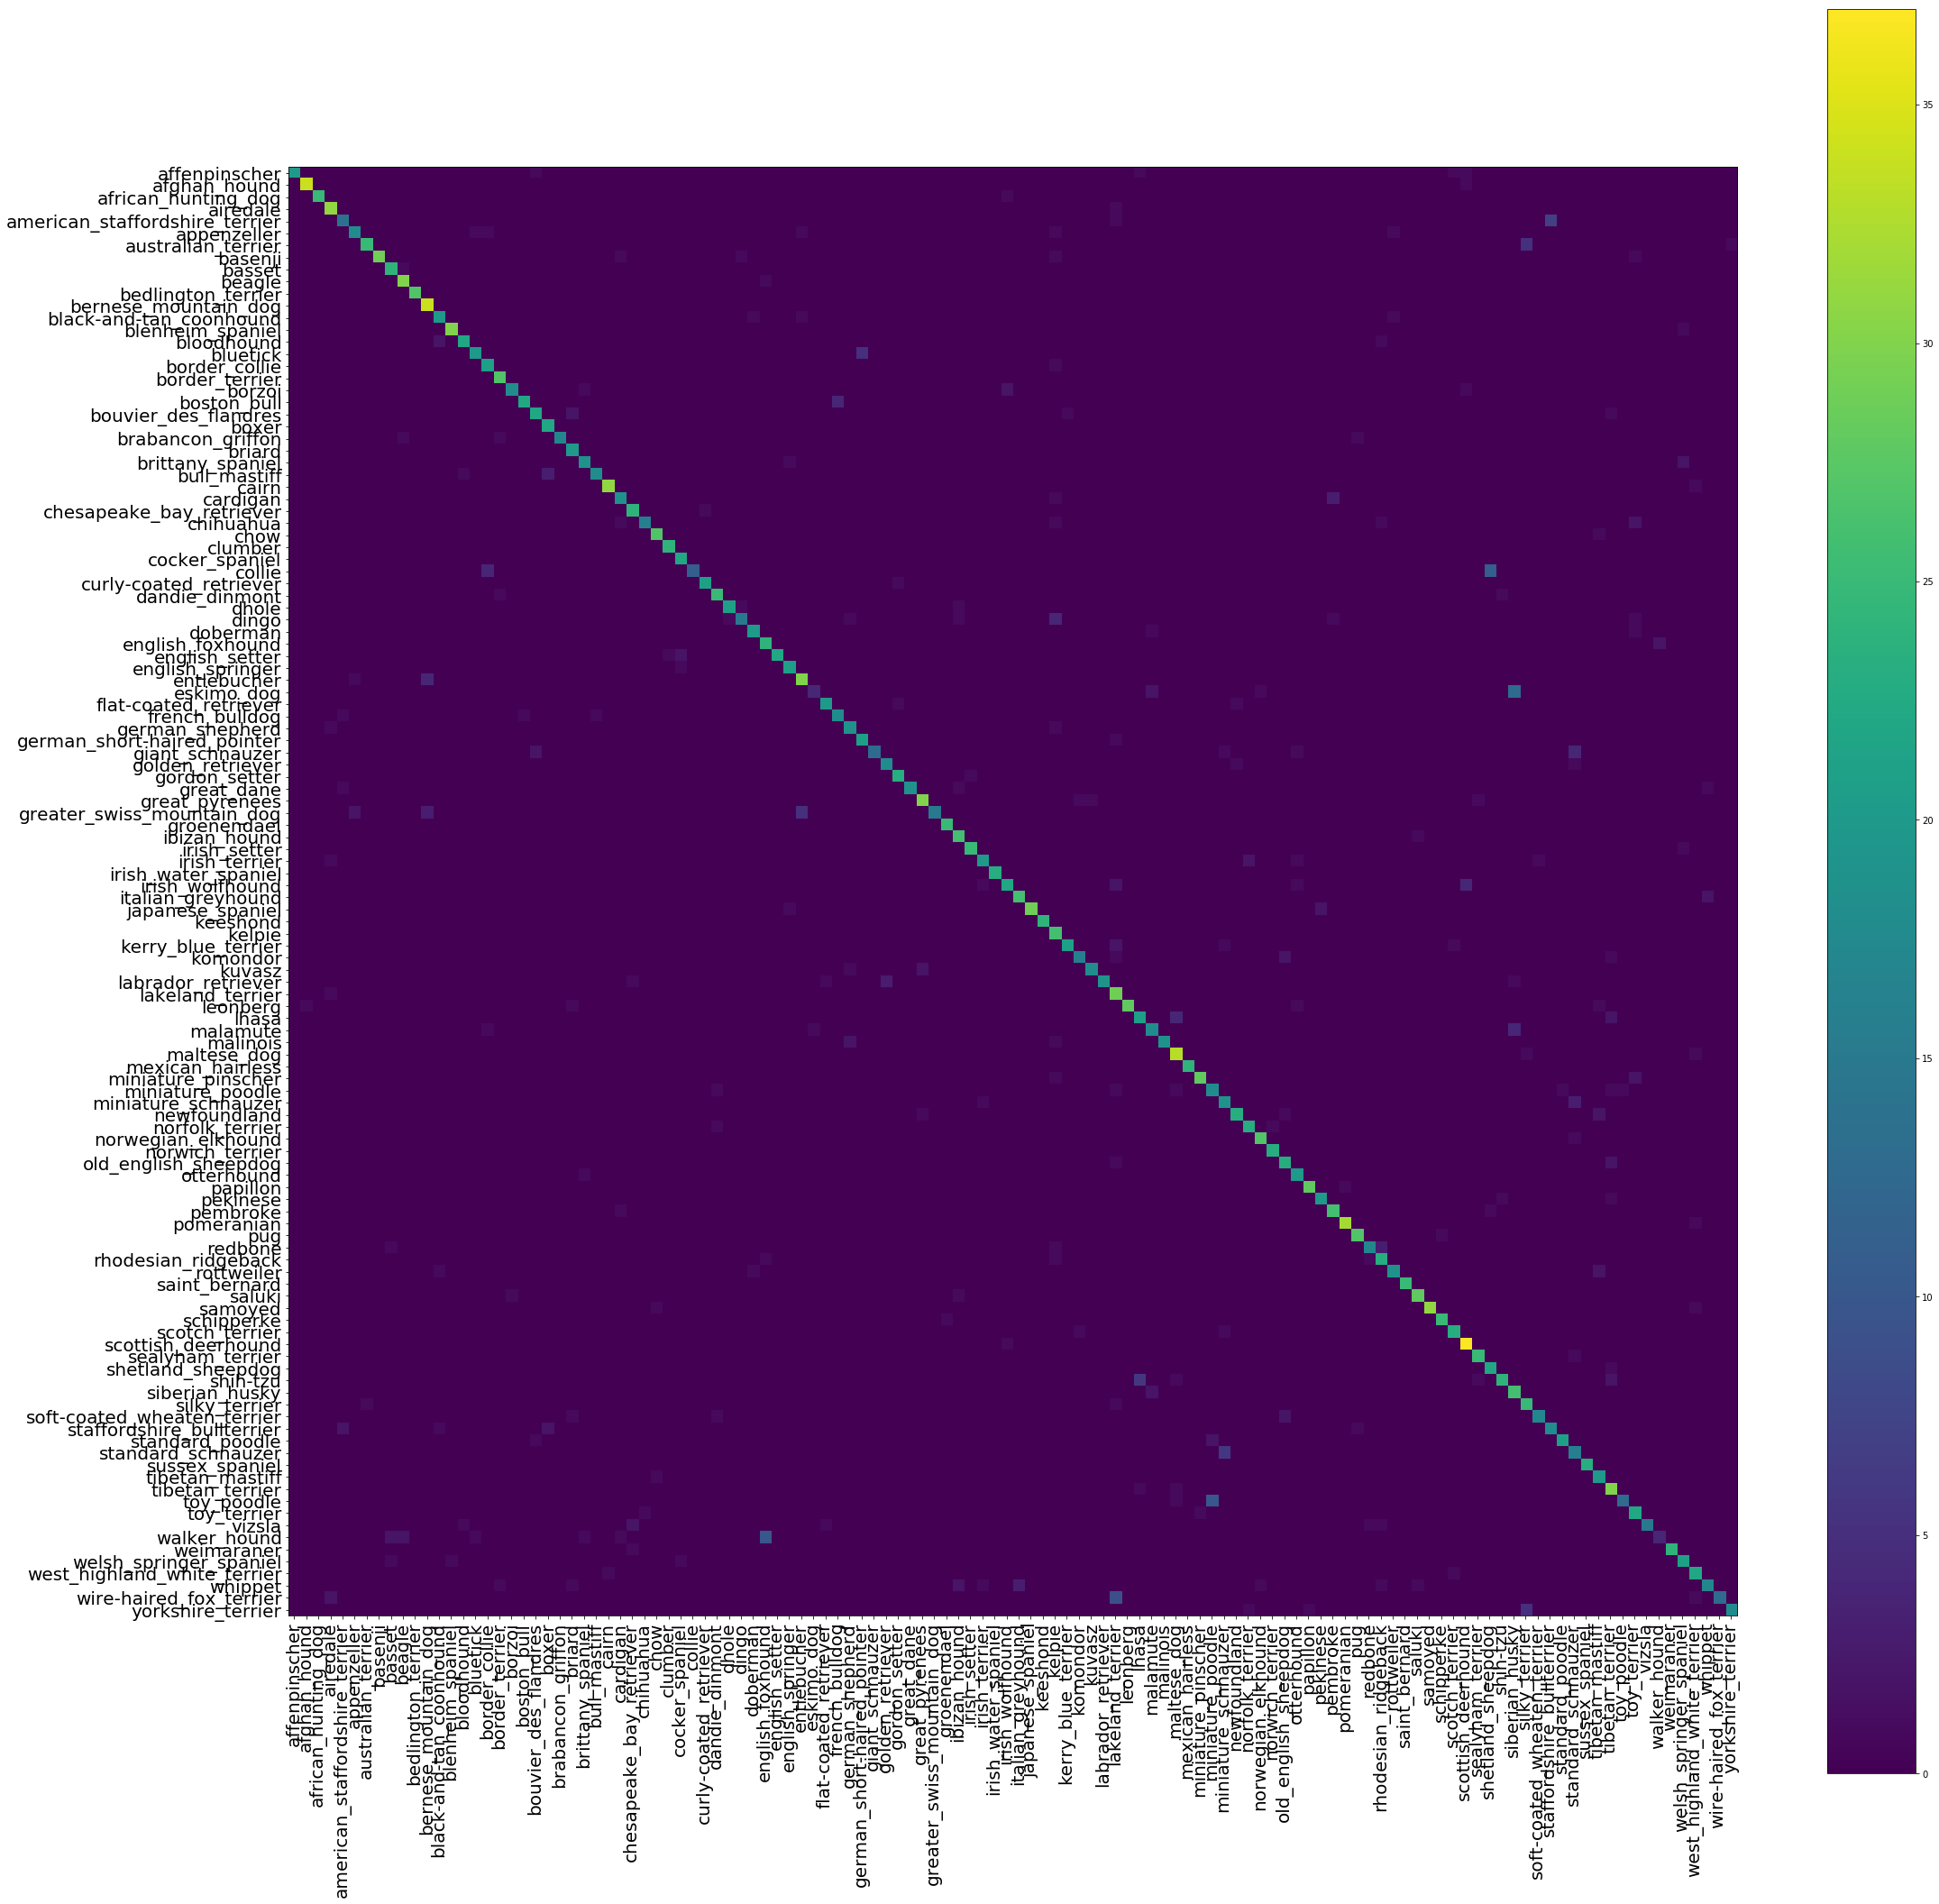

In [53]:
plt.figure(figsize=(36,36)),
plt.imshow(cm, interpolation='nearest')
plt.colorbar()
tick_marks = np.arange(len(class_n))
_ = plt.xticks(tick_marks, class_n, rotation=90,fontsize = 20)
_ = plt.yticks(tick_marks, class_n,fontsize = 20)

## Visualizing Model Performance
Visualize model performance with actual images, labels and prediction confidence

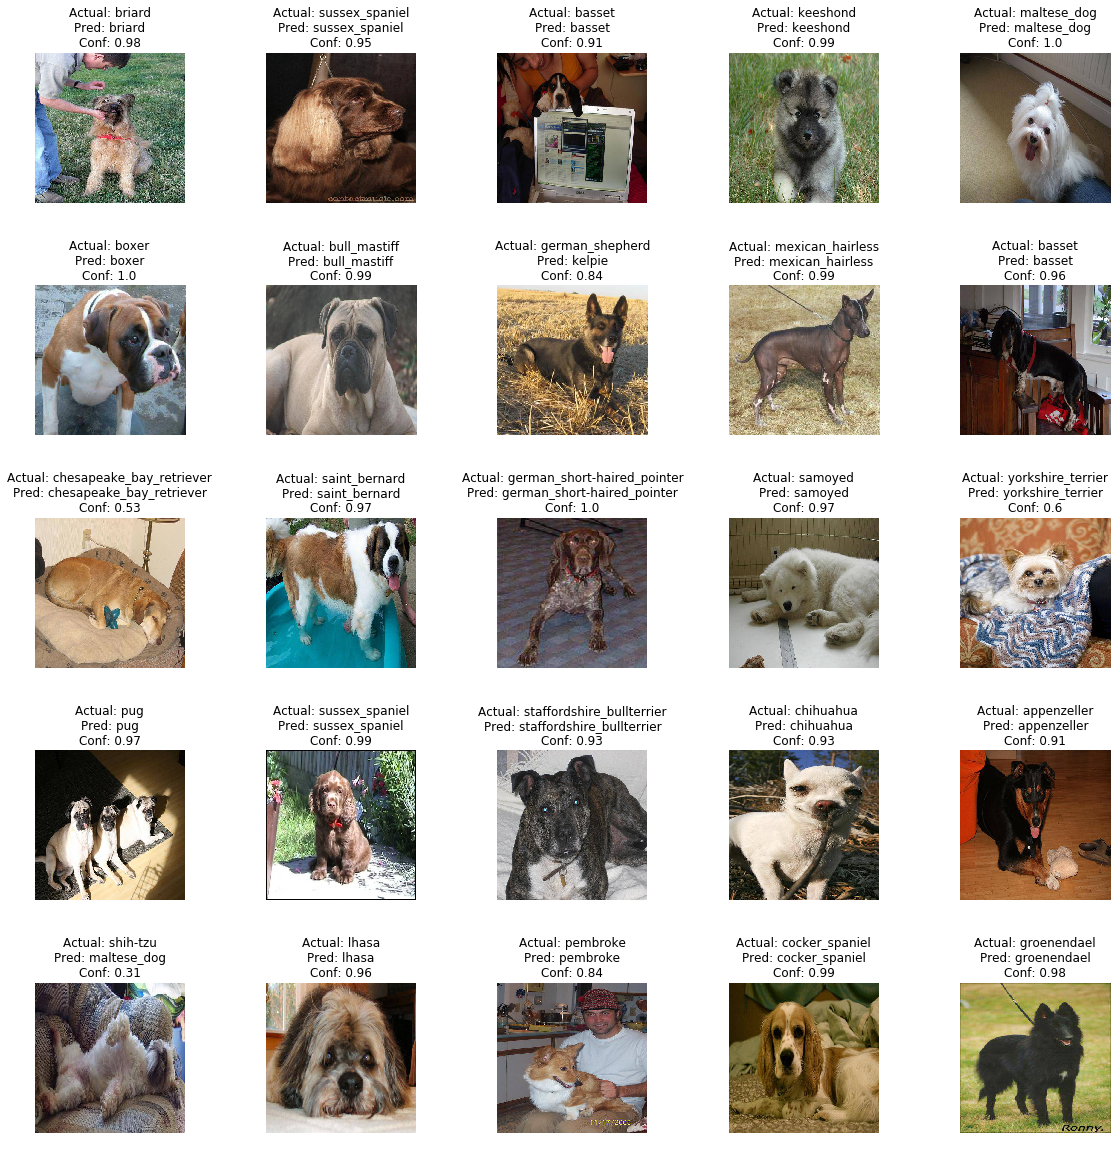

In [54]:
grid_width = 5
grid_height = 5
f, ax = plt.subplots(grid_width, grid_height)
f.set_size_inches(15, 15)
batch_size = 25
dataset = x_test

label_dict = dict(enumerate(labels_ohe_names.columns.values))
model_input_shape = (1,)+model.get_input_shape_at(0)[1:]
random_batch_indx = np.random.permutation(np.arange(0,len(dataset)))[:batch_size]

img_idx = 0
for i in range(0, grid_width):
    for j in range(0, grid_height):
        actual_label = np.array(y_test)[random_batch_indx[img_idx]]
        prediction = model.predict(dataset[random_batch_indx[img_idx]].reshape(model_input_shape))[0]
        label_idx = np.argmax(prediction)
        predicted_label = label_dict.get(label_idx)
        conf = round(prediction[label_idx], 2)
        ax[i][j].axis('off')
        ax[i][j].set_title('Actual: '+actual_label+'\nPred: '+predicted_label + '\nConf: ' +str(conf))
        ax[i][j].imshow(dataset[random_batch_indx[img_idx]])
        img_idx += 1

plt.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=0.5, hspace=0.55)    

In [ ]:
from keras.utils.vis_utils import plot_model

plot_model(model, to_file='dog_breed_inceptionv3_model.png', show_shapes=True, show_layer_names=True)